# Lab CMBLenses

## Model

In [1]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [2]:
using Revise
using MicroCanonicalHMC

In [3]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

In [4]:
target = CMBLensingTarget(prob);

## Sample

In [5]:
spl=MCHMC(0.1, 0.01*sqrt(50); sigma=one(LenseBasis(diag(target.Λmass))))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 0.2, 0, 1000, 10, "LF"), Hyperparameters(0.1, 0.07071067811865475, 0.0, 0.1931833275037836, Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [6]:
samples = Sample(spl, target, 500;
                 monitor_energy=true, dialog=true)

501-element Vector{Any}:
 Any[Float32[0.24073595, 1.621628, -1.8801293, -3.269616, 0.8715595, 2.253, -1.2389673, -2.6320498, 1.8757324, 3.258451  …  -3.39584f-9, 3.6597725f-11, 4.6774042f-9, 1.2117561f-9, -5.81023f-9, -2.336003f-9, 2.561252f-9, -9.1428076f-10, -1.609438, 0.0], 0.0, 376.9970397949219]
 Any[[0.23830036871951266, 1.61297594754535, -1.8673530040285538, -3.269233163895919, 0.8652887152963966, 2.2662483827931714, -1.2372540510400196, -2.629654564212175, 1.870890125418085, 3.2558903316427945  …  -3.98120300495592e-9, -2.54819584223763e-10, 4.498465712180042e-9, 9.449517934330122e-10, -5.706825514495621e-9, -2.3038304209547125e-9, 2.961615066846803e-9, -2.288814938658116e-10, -1.6058843340545244, -0.009725632124679265], 2.0319858208495134e-5, 376.9973807028948]
 Any[[0.25520616172448474, 1.6108877735763514, -1.8488372743585288, -3.2793571330209472, 0.8532060649953421, 2.264693823152442, -1.237349901043244, -2.626345878679802, 1.8673425738067335, 3.2722438877784836  …  -3.75490

## Plotting

In [7]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [8]:
rs = [Vector(sample[1])[end-1] for sample in samples]
Aϕs = [Vector(sample[1])[end] for sample in samples];

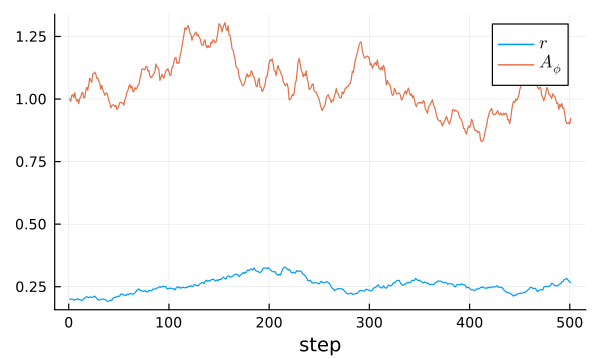

In [9]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


In [10]:
Energy = [sample[end-1] for sample in samples]

501-element Vector{Float64}:
  0.0
  2.0319858208495134e-5
 -0.0003732135384666435
  ⋮
  0.0003114695977046722
  0.0012888058695921245

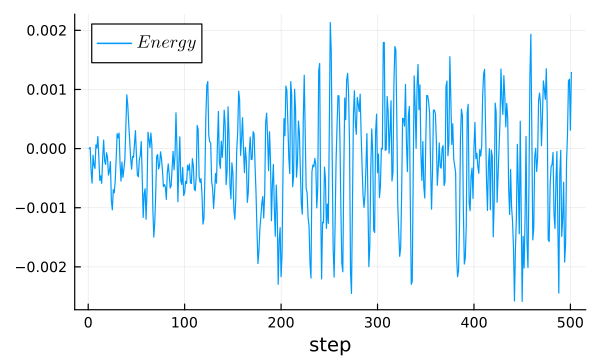

In [11]:
plot(Energy, label=L"Energy", xlabel="step")

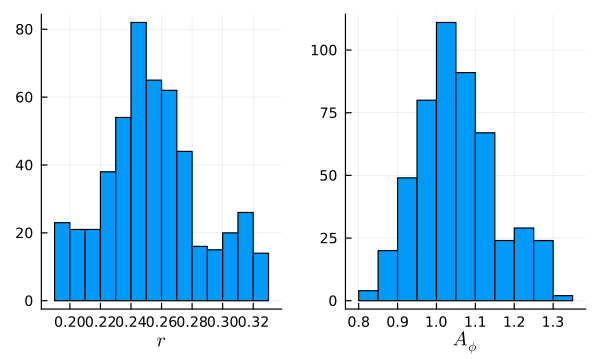

In [12]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))